# 04_标签定义_正确方法 - GLP-1临床试验风险预测

## 📊 功能概述

本notebook实现风险标签的正确定义方法，基于真实试验结果定义高风险和低风险标签：

1. **数据准备** - 加载特征数据和试验状态数据
2. **标签定义逻辑** - 基于试验状态和安全关键词定义风险标签
3. **标签分布分析** - 分析风险标签的分布情况
4. **标签质量评估** - 评估标签定义的质量和合理性
5. **数据保存** - 保存带标签的特征数据

## 🚀 运行说明

直接运行所有单元格即可完成标签定义。

**输入文件**: 
- `processed_data/glp1_18clinical_features.csv` - 特征数据
- `data/raw/studies.txt` - 试验状态数据

**输出文件**: 
- `processed_data/glp1_18clinical_features_with_labels_correct.csv` - 带标签的特征数据
- `results/label_distribution_report.csv` - 标签分布报告

## 📝 学习目标

通过本notebook，您将学习：
- 如何基于真实数据定义风险标签
- 临床试验风险标签的定义逻辑和方法
- 标签质量评估的标准和技巧
- 数据不平衡问题的识别和处理

## 🎯 标签定义理念

本方法基于真实试验结果定义风险标签：
- **高风险**: 试验状态为TERMINATED、WITHDRAWN或SUSPENDED，且why_stopped字段包含安全性关键词
- **低风险**: 其他所有试验

这种方法避免了循环推理，确保标签定义基于真实结果而非特征本身。

## 1. 导入必要的库

**📝 讲解**: 标签定义需要多种数据处理和文本分析库的支持：

- **pandas**: 数据框操作和标签定义
- **numpy**: 数值计算
- **re**: 正则表达式，用于文本模式匹配
- **os**: 文件路径操作
- **sys**: 系统路径管理
- **datetime**: 日期时间处理
- **matplotlib**: 数据可视化
- **seaborn**: 统计可视化

**💡 技术要点**: 
- 设置中文字体确保图表正确显示中文
- 添加项目路径确保模块导入正确

In [21]:
# 导入标签定义所需的库
import pandas as pd
import numpy as np
import re
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm  # 用于动态检测中文字体

# ========== 中文字体配置（增强版）==========
print("🔧 设置中文字体配置...")

# 常见中文字体名称列表（涵盖 Windows、macOS、Linux）
chinese_font_names = [
    'SimHei', 'Microsoft YaHei',          # Windows
    'PingFang SC', 'STHeiti',              # macOS
    'WenQuanYi Zen Hei', '文泉驿正黑',      # Linux
    'Noto Sans CJK SC', 'Droid Sans Fallback'
]

# 获取当前系统中所有可用字体名称
available_fonts = [f.name for f in fm.fontManager.ttflist]

# 找出第一个可用的中文字体
selected_font = None
for font in chinese_font_names:
    if font in available_fonts:
        selected_font = font
        break

if selected_font is None:
    print("⚠️ 未找到已知中文字体，中文可能无法正确显示，将使用系统默认 sans-serif 字体。")
    selected_font = 'sans-serif'
else:
    print(f"✅ 找到可用中文字体: {selected_font}")

# 设置 matplotlib 参数
plt.rcParams['font.sans-serif'] = [selected_font] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 设置图表风格
sns.set_style('whitegrid')

# 再次确认字体设置（防止风格覆盖）
plt.rcParams['font.sans-serif'] = [selected_font] + [f for f in plt.rcParams['font.sans-serif'] if f != selected_font]
plt.rcParams['axes.unicode_minus'] = False

print("✅ 字体配置完成")
print(f"📋 最终字体列表: {plt.rcParams['font.sans-serif']}")
print(f"📋 负号显示: {plt.rcParams['axes.unicode_minus']}")
# ==========================================

# 添加项目根目录到路径，确保可以导入项目中的其他模块
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

print("✅ 库导入完成")
print(f"当前工作目录: {os.getcwd()}")
print(f"Pandas版本: {pd.__version__}")
print(f"NumPy版本: {np.__version__}")
print(f"处理开始时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔧 设置中文字体配置...
✅ 找到可用中文字体: SimHei
✅ 字体配置完成
📋 最终字体列表: ['SimHei', 'Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
📋 负号显示: False
✅ 库导入完成
当前工作目录: d:\projects\glp1-trial-risk-prediction\glp1-risk-prediction\notebooks
Pandas版本: 2.3.3
NumPy版本: 2.2.6
处理开始时间: 2026-02-27 15:43:07


## 2. 加载特征数据

**📝 讲解**: 加载由特征工程脚本生成的特征数据：

- 检查特征数据文件是否存在
- 加载数据并进行基本的数据质量检查
- 显示数据的基本信息和统计

**💡 技术要点**: 
- 使用`os.path.exists()`检查文件存在性
- 使用`pd.read_csv()`加载CSV文件
- 使用`info()`和`describe()`快速了解数据概况

In [22]:
# 检查特征数据是否存在
features_file = os.path.join('..', 'processed_data', 'glp1_18clinical_features.csv')

if not os.path.exists(features_file):
    print("❌ 特征数据不存在，请先运行02_特征工程.ipynb")
else:
    print("✅ 特征数据存在，开始加载...")
    
    # 加载特征数据
    features_df = pd.read_csv(features_file)
    
    print(f"✅ 特征数据加载完成!")
    print(f"加载数据: {features_df.shape[0]} 行, {features_df.shape[1]} 列")
    
    # 显示数据基本信息
    print(f"\n📋 数据基本信息:")
    print(features_df.info())
    
    # 显示数据前5行
    print(f"\n📊 数据前5行:")
    display(features_df.head())
    
    # 显示特征列
    print(f"\n📋 特征列列表:")
    feature_columns = [col for col in features_df.columns if col != 'nct_id']
    for i, col in enumerate(feature_columns, 1):
        print(f"{i:2d}. {col}")
    
    # 显示数据类型统计
    print(f"\n📊 数据类型统计:")
    dtype_counts = features_df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"{dtype}: {count} 列")

✅ 特征数据存在，开始加载...
✅ 特征数据加载完成!
加载数据: 30105 行, 19 列

📋 数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30105 entries, 0 to 30104
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   nct_id                          30105 non-null  object 
 1   enrollment_log                  30105 non-null  float64
 2   start_year                      30105 non-null  float64
 3   pre_semaglutide_era             30105 non-null  int64  
 4   post_semaglutide_era            30105 non-null  int64  
 5   phase_Unknown                   30105 non-null  int64  
 6   phase_PHASE4                    30105 non-null  int64  
 7   is_obesity                      30105 non-null  int64  
 8   is_t2d                          30105 non-null  int64  
 9   is_weight_loss                  30105 non-null  int64  
 10  exc_count                       30105 non-null  int64  
 11  criteria_total_len              3

,nct_id,enrollment_log,start_year,pre_semaglutide_era,post_semaglutide_era,phase_Unknown,phase_PHASE4,is_obesity,is_t2d,is_weight_loss,exc_count,criteria_total_len,mentions_bmi,mentions_contraindication,mentions_renal_cutoff,high_risk_term_count,risk_ratio,year_x_enrollment,enrollment_log_x_phase_Unknown
0,NCT00438555,5.517453,2006.0,1,0,0,0,1,0,0,0,234,1,0,0,0,0.0,11068.010510,0.0
1,NCT04272073,5.484797,2022.0,0,1,0,0,1,0,0,0,697,0,0,0,0,0.0,11090.259400,0.0
2,NCT03748433,3.583519,2019.0,0,1,0,0,0,0,0,0,1130,0,0,0,1,1.0,7235.124737,0.0
3,NCT02706067,3.931826,2002.0,1,0,0,0,1,0,1,0,917,1,1,0,1,1.0,7871.514917,0.0
4,NCT01740817,2.564949,2008.0,1,0,0,0,1,0,0,0,2513,0,0,1,0,0.0,5150.418310,0.0



📋 特征列列表:
 1. enrollment_log
 2. start_year
 3. pre_semaglutide_era
 4. post_semaglutide_era
 5. phase_Unknown
 6. phase_PHASE4
 7. is_obesity
 8. is_t2d
 9. is_weight_loss
10. exc_count
11. criteria_total_len
12. mentions_bmi
13. mentions_contraindication
14. mentions_renal_cutoff
15. high_risk_term_count
16. risk_ratio
17. year_x_enrollment
18. enrollment_log_x_phase_Unknown

📊 数据类型统计:
int64: 13 列
float64: 5 列
object: 1 列


## 3. 加载试验状态数据

**📝 讲解**: 加载原始试验状态数据，用于定义风险标签：

- 检查原始数据文件是否存在
- 加载studies.txt文件
- 选择需要的列（nct_id, overall_status, why_stopped）
- 处理缺失值和数据类型转换

**💡 技术要点**: 
- studies.txt使用竖线分隔符`|`
- 使用`dtype=str`确保所有列都作为字符串加载
- 使用`low_memory=False`避免内存警告

In [23]:
# 检查原始数据是否存在
studies_file = os.path.join('..', 'data', 'raw', 'studies.txt')

if not os.path.exists(studies_file):
    print("❌ 原始数据不存在，请检查raw_data文件夹")
else:
    print("✅ 原始数据存在，开始加载...")
    
    # 加载studies.txt文件（注意分隔符为竖线 '|'）
    studies = pd.read_csv(studies_file, sep='|', dtype=str, low_memory=False)
    
    print(f"✅ 原始数据加载完成!")
    print(f"加载数据: {studies.shape[0]} 行, {studies.shape[1]} 列")
    
    # 选择需要的列
    studies_selected = studies[['nct_id', 'overall_status', 'why_stopped']].copy()
    
    # 处理缺失值
    studies_selected['overall_status'] = studies_selected['overall_status'].fillna('')
    studies_selected['why_stopped'] = studies_selected['why_stopped'].fillna('')
    
    print(f"\n📊 试验状态数据概览:")
    print(f"   - 唯一试验数量: {studies_selected['nct_id'].nunique()}")
    print(f"   - 有状态信息的试验: {studies_selected[studies_selected['overall_status'] != ''].shape[0]}")
    print(f"   - 有停止原因信息的试验: {studies_selected[studies_selected['why_stopped'] != ''].shape[0]}")
    
    # 显示试验状态分布
    print(f"\n📊 试验状态分布:")
    status_counts = studies_selected['overall_status'].value_counts().head(10)
    for status, count in status_counts.items():
        print(f"   - {status}: {count} 个试验")
    
    # 显示数据前5行
    print(f"\n📊 试验状态数据前5行:")
    display(studies_selected.head())
    
    # 保存试验状态数据供后续使用
    studies_data = studies_selected

✅ 原始数据存在，开始加载...
✅ 原始数据加载完成!
加载数据: 568538 行, 71 列

📊 试验状态数据概览:
   - 唯一试验数量: 568538
   - 有状态信息的试验: 568538
   - 有停止原因信息的试验: 44620

📊 试验状态分布:
   - COMPLETED: 310933 个试验
   - UNKNOWN: 86989 个试验
   - RECRUITING: 65700 个试验
   - TERMINATED: 32774 个试验
   - NOT_YET_RECRUITING: 26038 个试验
   - ACTIVE_NOT_RECRUITING: 21486 个试验
   - WITHDRAWN: 15953 个试验
   - ENROLLING_BY_INVITATION: 4999 个试验
   - SUSPENDED: 1672 个试验
   - WITHHELD: 966 个试验

📊 试验状态数据前5行:


,nct_id,overall_status,why_stopped
0,NCT03729011,COMPLETED,
1,NCT04599764,RECRUITING,
2,NCT06337526,NOT_YET_RECRUITING,
3,NCT03538041,COMPLETED,
4,NCT05573191,UNKNOWN,


## 4. 合并特征数据和试验状态数据

**📝 讲解**: 将特征数据与试验状态数据进行合并：

- 使用nct_id作为连接键
- 使用左连接保留所有特征数据
- 处理合并后的缺失值
- 检查合并结果的数据质量

**💡 技术要点**: 
- 使用`merge()`进行数据合并
- 使用`how='left'`确保保留所有特征数据
- 使用`on='nct_id'`指定连接键

In [24]:
print("🔗 合并特征数据和试验状态数据...")

# 合并数据（左连接，保留所有特征数据）
merged_df = features_df.merge(studies_data, on='nct_id', how='left')

# 处理合并后的缺失值
merged_df['overall_status'] = merged_df['overall_status'].fillna('')
merged_df['why_stopped'] = merged_df['why_stopped'].fillna('')

print(f"✅ 数据合并完成!")
print(f"合并后数据: {merged_df.shape[0]} 行, {merged_df.shape[1]} 列")

# 检查合并结果
print(f"\n📊 合并结果检查:")
print(f"   - 成功匹配的试验: {merged_df[merged_df['overall_status'] != ''].shape[0]}")
print(f"   - 未匹配的试验: {merged_df[merged_df['overall_status'] == ''].shape[0]}")
print(f"   - 匹配成功率: {merged_df[merged_df['overall_status'] != ''].shape[0] / len(merged_df) * 100:.2f}%")

# 显示合并后的数据前5行
print(f"\n📊 合并后数据前5行:")
display(merged_df.head())

# 显示合并后试验状态分布
print(f"\n📊 合并后试验状态分布:")
status_counts = merged_df['overall_status'].value_counts().head(10)
for status, count in status_counts.items():
    print(f"   - {status}: {count} 个试验")

🔗 合并特征数据和试验状态数据...
✅ 数据合并完成!
合并后数据: 30105 行, 21 列

📊 合并结果检查:
   - 成功匹配的试验: 30105
   - 未匹配的试验: 0
   - 匹配成功率: 100.00%

📊 合并后数据前5行:


,nct_id,enrollment_log,start_year,pre_semaglutide_era,post_semaglutide_era,phase_Unknown,phase_PHASE4,is_obesity,is_t2d,is_weight_loss,...,criteria_total_len,mentions_bmi,mentions_contraindication,mentions_renal_cutoff,high_risk_term_count,risk_ratio,year_x_enrollment,enrollment_log_x_phase_Unknown,overall_status,why_stopped
0,NCT00438555,5.517453,2006.0,1,0,0,0,1,0,0,...,234,1,0,0,0,0.0,11068.010510,0.0,COMPLETED,
1,NCT04272073,5.484797,2022.0,0,1,0,0,1,0,0,...,697,0,0,0,0,0.0,11090.259400,0.0,UNKNOWN,
2,NCT03748433,3.583519,2019.0,0,1,0,0,0,0,0,...,1130,0,0,0,1,1.0,7235.124737,0.0,TERMINATED,Terminated early after the interim analysis. I...
3,NCT02706067,3.931826,2002.0,1,0,0,0,1,0,1,...,917,1,1,0,1,1.0,7871.514917,0.0,COMPLETED,
4,NCT01740817,2.564949,2008.0,1,0,0,0,1,0,0,...,2513,0,0,1,0,0.0,5150.418310,0.0,COMPLETED,



📊 合并后试验状态分布:
   - COMPLETED: 19020 个试验
   - UNKNOWN: 3731 个试验
   - RECRUITING: 2853 个试验
   - TERMINATED: 1306 个试验
   - ACTIVE_NOT_RECRUITING: 1074 个试验
   - NOT_YET_RECRUITING: 1053 个试验
   - WITHDRAWN: 701 个试验
   - ENROLLING_BY_INVITATION: 274 个试验
   - SUSPENDED: 80 个试验
   - NO_LONGER_AVAILABLE: 6 个试验


## 5. 定义风险标签函数

**📝 讲解**: 定义基于试验状态和安全关键词的风险标签函数：

### 高风险条件
1. **试验状态**: TERMINATED、WITHDRAWN或SUSPENDED
2. **停止原因**: 包含安全性关键词

### 安全性关键词列表
- safety, adverse, toxicity, side effect, unsafe
- death, fatal, severe, serious, unethical, harm
- patient died, mortality, elevated liver enzymes
- pancreatitis, hypoglycemia, cardiovascular, stroke
- hospitalization, withdrawn due to ae

**💡 技术要点**: 
- 使用正则表达式进行文本匹配
- 将文本转换为小写确保匹配准确性
- 使用`re.search()`进行模式匹配

In [25]:
# 全局安全性关键词列表（不区分大小写）
safety_keywords = [
    'safety', 'adverse', 'toxicity', 'side effect', 'unsafe',
    'death', 'fatal', 'severe', 'serious', 'unethical', 'harm',
    'patient died', 'mortality', 'elevated liver enzymes',
    'pancreatitis', 'hypoglycemia', 'cardiovascular', 'stroke',
    'hospitalization', 'withdrawn due to ae'  # AE = adverse event
]

def is_high_risk(row):
    """
    判断试验是否为高风险
    
    高风险条件：
    1. 试验状态为 TERMINATED、WITHDRAWN 或 SUSPENDED
    2. why_stopped 字段包含安全性关键词
    
    参数:
        row: DataFrame 行
    
    返回:
        int: 1=高风险, 0=低风险
    """
    # 只处理终止状态
    if row['overall_status'] not in ['TERMINATED', 'WITHDRAWN', 'SUSPENDED']:
        return 0  # 低风险
    
    # 检查 why_stopped 字段
    why = str(row['why_stopped']).lower() if pd.notna(row['why_stopped']) else ''
    
    # 检查是否包含任何安全性关键词
    for kw in safety_keywords:
        if re.search(kw, why):
            return 1
    
    return 0  # 低风险

print("🔍 定义风险标签函数完成")
print(f"安全性关键词数量: {len(safety_keywords)}")
print("\n📋 安全性关键词列表:")
for i, kw in enumerate(safety_keywords, 1):
    print(f"{i:2d}. {kw}")

# 测试风险标签函数
print(f"\n🧪 风险标签函数测试:")
test_cases = [
    {'overall_status': 'TERMINATED', 'why_stopped': 'Safety concerns'},
    {'overall_status': 'COMPLETED', 'why_stopped': 'Normal completion'},
    {'overall_status': 'TERMINATED', 'why_stopped': 'Lack of funding'},
    {'overall_status': 'WITHDRAWN', 'why_stopped': 'Adverse events reported'}
]

for i, test_case in enumerate(test_cases, 1):
    risk = is_high_risk(test_case)
    status = test_case['overall_status']
    why = test_case['why_stopped']
    risk_label = '高风险' if risk == 1 else '低风险'
    print(f"测试案例 {i}: 状态={status}, 原因={why} → {risk_label}")

🔍 定义风险标签函数完成
安全性关键词数量: 20

📋 安全性关键词列表:
 1. safety
 2. adverse
 3. toxicity
 4. side effect
 5. unsafe
 6. death
 7. fatal
 8. severe
 9. serious
10. unethical
11. harm
12. patient died
13. mortality
14. elevated liver enzymes
15. pancreatitis
16. hypoglycemia
17. cardiovascular
18. stroke
19. hospitalization
20. withdrawn due to ae

🧪 风险标签函数测试:
测试案例 1: 状态=TERMINATED, 原因=Safety concerns → 高风险
测试案例 2: 状态=COMPLETED, 原因=Normal completion → 低风险
测试案例 3: 状态=TERMINATED, 原因=Lack of funding → 低风险
测试案例 4: 状态=WITHDRAWN, 原因=Adverse events reported → 高风险


## 6. 应用风险标签

**📝 讲解**: 将风险标签函数应用到所有试验数据：

- 使用`apply()`函数逐行应用风险标签函数
- 创建新的risk_label列
- 分析风险标签的分布情况
- 检查高风险试验的具体情况

**💡 技术要点**: 
- 使用`axis=1`逐行应用函数
- 使用`value_counts()`统计标签分布
- 使用`groupby()`按状态分组统计

In [26]:
print("🏷️ 应用风险标签...")

# 应用风险标签函数
merged_df['risk_label'] = merged_df.apply(is_high_risk, axis=1)

print(f"✅ 风险标签应用完成!")

# 分析风险标签分布
print(f"\n📊 风险标签分布:")
label_counts = merged_df['risk_label'].value_counts()
total_trials = len(merged_df)

for label, count in label_counts.items():
    label_name = '高风险' if label == 1 else '低风险'
    percentage = count / total_trials * 100
    print(f"{label_name}: {count} 个试验 ({percentage:.2f}%)")

# 按试验状态分析风险标签
print(f"\n📊 按试验状态分析风险标签:")
status_risk = merged_df.groupby(['overall_status', 'risk_label']).size().unstack(fill_value=0)
status_risk['高风险比例'] = status_risk[1] / (status_risk[0] + status_risk[1]) * 100

display(status_risk.round(2))

# 显示高风险试验的具体信息
high_risk_trials = merged_df[merged_df['risk_label'] == 1]
if len(high_risk_trials) > 0:
    print(f"\n📋 高风险试验详细信息 (前5个):")
    for i, (idx, row) in enumerate(high_risk_trials.head().iterrows(), 1):
        print(f"{i}. NCT ID: {row['nct_id']}")
        print(f"   状态: {row['overall_status']}")
        print(f"   停止原因: {row['why_stopped']}")
        print()
else:
    print("\n⚠️ 未发现高风险试验")

# 显示数据前5行（包含风险标签）
print(f"\n📊 带标签数据前5行:")
display(merged_df.head())

🏷️ 应用风险标签...
✅ 风险标签应用完成!

📊 风险标签分布:
低风险: 30000 个试验 (99.65%)
高风险: 105 个试验 (0.35%)

📊 按试验状态分析风险标签:


risk_label,0,1,高风险比例
overall_status,,,
ACTIVE_NOT_RECRUITING,1074,0,0.00
APPROVED_FOR_MARKETING,4,0,0.00
AVAILABLE,2,0,0.00
COMPLETED,19020,0,0.00
ENROLLING_BY_INVITATION,274,0,0.00
NOT_YET_RECRUITING,1053,0,0.00
NO_LONGER_AVAILABLE,6,0,0.00
RECRUITING,2853,0,0.00
SUSPENDED,75,5,6.25



📋 高风险试验详细信息 (前5个):
1. NCT ID: NCT03748433
   状态: TERMINATED
   停止原因: Terminated early after the interim analysis. It was deemed unethical to offer self-monitored blood glucose to this high risk population

2. NCT ID: NCT03349775
   状态: TERMINATED
   停止原因: After discussion with the Data Safety Monitoring Board and NIH, the randomized clinical trial involving metformin vs. placebo is terminated due to slow enrollment in the setting of the COVID-19 pandemic.

3. NCT ID: NCT03277742
   状态: WITHDRAWN
   停止原因: Due to safety reasons. The region was considered too dangerous.

4. NCT ID: NCT04134143
   状态: TERMINATED
   停止原因: Business decision - not related to product quality or safety concerns

5. NCT ID: NCT03785236
   状态: TERMINATED
   停止原因: Suitable participants have complicated T1D, often with serious complications, participation is therefore challenging. Participants also fall within an unique group and few suitable individuals were available for inclusion.


📊 带标签数据前5行:


,nct_id,enrollment_log,start_year,pre_semaglutide_era,post_semaglutide_era,phase_Unknown,phase_PHASE4,is_obesity,is_t2d,is_weight_loss,...,mentions_bmi,mentions_contraindication,mentions_renal_cutoff,high_risk_term_count,risk_ratio,year_x_enrollment,enrollment_log_x_phase_Unknown,overall_status,why_stopped,risk_label
0,NCT00438555,5.517453,2006.0,1,0,0,0,1,0,0,...,1,0,0,0,0.0,11068.010510,0.0,COMPLETED,,0
1,NCT04272073,5.484797,2022.0,0,1,0,0,1,0,0,...,0,0,0,0,0.0,11090.259400,0.0,UNKNOWN,,0
2,NCT03748433,3.583519,2019.0,0,1,0,0,0,0,0,...,0,0,0,1,1.0,7235.124737,0.0,TERMINATED,Terminated early after the interim analysis. I...,1
3,NCT02706067,3.931826,2002.0,1,0,0,0,1,0,1,...,1,1,0,1,1.0,7871.514917,0.0,COMPLETED,,0
4,NCT01740817,2.564949,2008.0,1,0,0,0,1,0,0,...,0,0,1,0,0.0,5150.418310,0.0,COMPLETED,,0


## 7. 标签质量评估

**📝 讲解**: 评估风险标签的质量和合理性：

- **数据不平衡评估**: 检查高风险和低风险的比例
- **标签一致性评估**: 检查相同状态的试验是否被正确分类
- **关键词匹配评估**: 检查安全性关键词的匹配情况
- **临床合理性评估**: 评估标签定义的临床合理性

**💡 技术要点**: 
- 使用自定义评分标准评估标签质量
- 分析高风险试验的特征分布
- 检查标签定义的逻辑一致性

In [27]:
print("🔍 评估标签质量...")

# 标签质量评估
total_trials = len(merged_df)
high_risk_count = merged_df['risk_label'].sum()
low_risk_count = total_trials - high_risk_count

# 数据不平衡评估
imbalance_ratio = high_risk_count / low_risk_count if low_risk_count > 0 else float('inf')

# 标签一致性评估
terminated_trials = merged_df[merged_df['overall_status'].isin(['TERMINATED', 'WITHDRAWN', 'SUSPENDED'])]
terminated_count = len(terminated_trials)
high_risk_in_terminated = terminated_trials['risk_label'].sum()
consistency_ratio = high_risk_in_terminated / terminated_count if terminated_count > 0 else 0

# 关键词匹配评估
safety_keyword_matches = 0
for idx, row in merged_df.iterrows():
    why = str(row['why_stopped']).lower()
    for kw in safety_keywords:
        if re.search(kw, why):
            safety_keyword_matches += 1
            break

keyword_match_ratio = safety_keyword_matches / len(merged_df) if len(merged_df) > 0 else 0

# 质量评分
quality_score = 100

# 数据不平衡扣分
if imbalance_ratio < 0.01 or imbalance_ratio > 0.5:
    quality_score -= 20
elif imbalance_ratio < 0.05 or imbalance_ratio > 0.2:
    quality_score -= 10

# 标签一致性扣分
if consistency_ratio < 0.3 or consistency_ratio > 0.9:
    quality_score -= 15

# 关键词匹配扣分
if keyword_match_ratio < 0.01:
    quality_score -= 10

# 质量等级
if quality_score >= 90:
    quality_grade = '优秀'
elif quality_score >= 80:
    quality_grade = '良好'
elif quality_score >= 70:
    quality_grade = '一般'
else:
    quality_grade = '较差'

# 显示标签质量评估结果
print(f"\n📊 标签质量评估结果:")
print(f"   总试验数: {total_trials}")
print(f"   高风险试验数: {high_risk_count}")
print(f"   低风险试验数: {low_risk_count}")
print(f"   不平衡比例: {imbalance_ratio:.3f}")
print(f"   终止试验中高风险比例: {consistency_ratio:.3f}")
print(f"   安全性关键词匹配比例: {keyword_match_ratio:.3f}")
print(f"   质量得分: {quality_score:.1f}")
print(f"   质量等级: {quality_grade}")

# 显示高风险试验的特征统计
if high_risk_count > 0:
    print(f"\n📊 高风险试验特征统计:")
    high_risk_features = merged_df[merged_df['risk_label'] == 1][feature_columns]
    
    # 计算均值
    high_risk_means = high_risk_features.mean()
    low_risk_means = merged_df[merged_df['risk_label'] == 0][feature_columns].mean()
    
    print(f"\n📋 高风险 vs 低风险特征均值对比:")
    comparison_df = pd.DataFrame({
        '高风险均值': high_risk_means,
        '低风险均值': low_risk_means,
        '差异': high_risk_means - low_risk_means
    }).round(3)
    
    display(comparison_df)
    
    # 显示差异较大的特征
    large_diff_features = comparison_df[comparison_df['差异'].abs() > 0.1].index.tolist()
    if large_diff_features:
        print(f"\n🔍 差异较大的特征 (|差异| > 0.1):")
        for feature in large_diff_features:
            diff = comparison_df.loc[feature, '差异']
            print(f"{feature}: 差异 = {diff:.3f}")
    else:
        print("\n⚠️ 未发现差异较大的特征")

🔍 评估标签质量...

📊 标签质量评估结果:
   总试验数: 30105
   高风险试验数: 105
   低风险试验数: 30000
   不平衡比例: 0.004
   终止试验中高风险比例: 0.050
   安全性关键词匹配比例: 0.003
   质量得分: 55.0
   质量等级: 较差

📊 高风险试验特征统计:

📋 高风险 vs 低风险特征均值对比:


,高风险均值,低风险均值,差异
enrollment_log,3.856,4.465,-0.609
start_year,2013.600,2015.725,-2.125
pre_semaglutide_era,0.667,0.501,0.166
post_semaglutide_era,0.333,0.499,-0.166
phase_Unknown,0.000,0.000,0.000
phase_PHASE4,0.000,0.000,0.000
is_obesity,0.181,0.386,-0.205
is_t2d,0.267,0.175,0.092
is_weight_loss,0.038,0.070,-0.032
exc_count,0.162,0.087,0.075



🔍 差异较大的特征 (|差异| > 0.1):
enrollment_log: 差异 = -0.609
start_year: 差异 = -2.125
pre_semaglutide_era: 差异 = 0.166
post_semaglutide_era: 差异 = -0.166
is_obesity: 差异 = -0.205
criteria_total_len: 差异 = 1252.592
mentions_renal_cutoff: 差异 = 0.203
high_risk_term_count: 差异 = 0.454
risk_ratio: 差异 = 0.421
year_x_enrollment: 差异 = -1237.152


## 8. 标签分布可视化

**📝 讲解**: 通过可视化图表展示风险标签的分布情况：

- **饼图**: 展示高风险和低风险的比例
- **柱状图**: 按试验状态展示风险标签分布
- **特征分布对比**: 高风险和低风险试验的特征分布对比
- **关键词词云**: 展示高风险试验的关键词分布

**💡 技术要点**: 
- 使用`plt.pie()`绘制饼图
- 使用`sns.barplot()`绘制柱状图
- 使用`sns.boxplot()`绘制箱线图对比分布

📈 生成标签分布可视化图表...


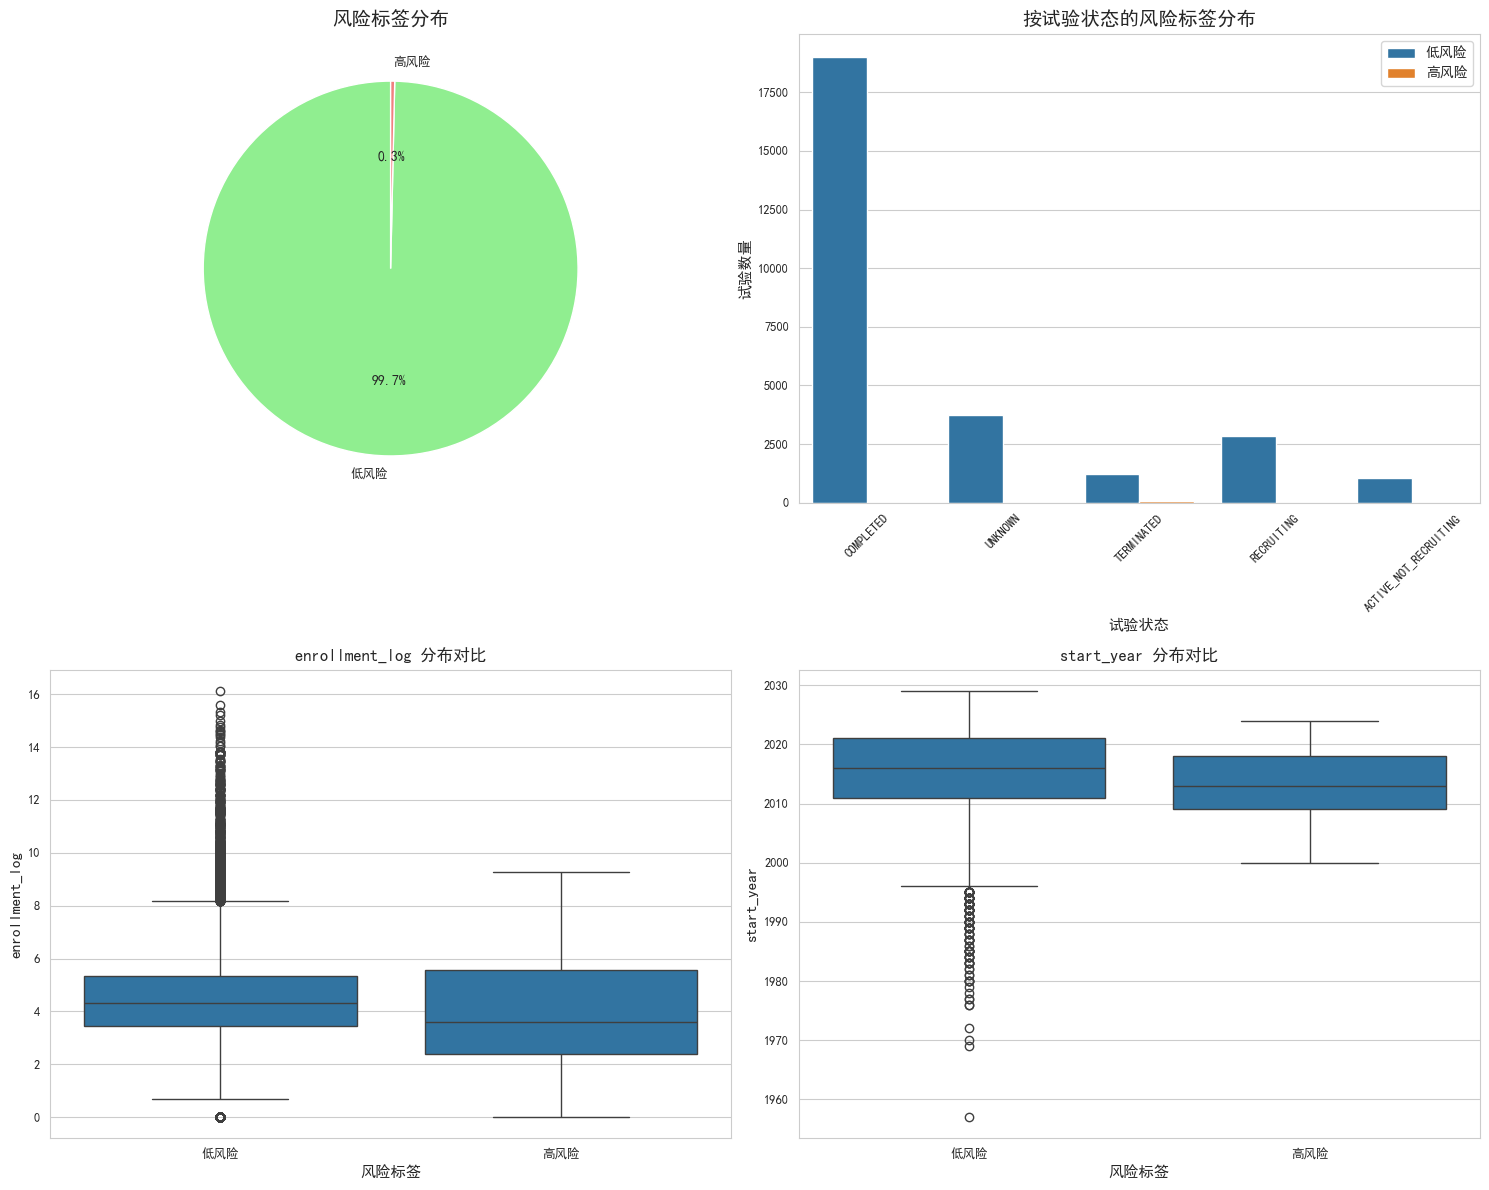

✅ 标签分布可视化完成

📊 高风险试验安全性关键词统计:
safety: 86 次出现
harm: 7 次出现
adverse: 5 次出现
severe: 2 次出现
unethical: 2 次出现
toxicity: 1 次出现
serious: 1 次出现
cardiovascular: 1 次出现
hospitalization: 1 次出现


In [28]:
print("📈 生成标签分布可视化图表...")

# 创建可视化图表
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 风险标签分布饼图
labels = ['低风险', '高风险']
sizes = [low_risk_count, high_risk_count]
colors = ['lightgreen', 'lightcoral']

axes[0, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('风险标签分布', fontsize=14, fontweight='bold')

# 2. 按试验状态的风险标签分布
top_statuses = merged_df['overall_status'].value_counts().head(5).index
status_risk_data = merged_df[merged_df['overall_status'].isin(top_statuses)]

sns.countplot(data=status_risk_data, x='overall_status', hue='risk_label', ax=axes[0, 1])
axes[0, 1].set_title('按试验状态的风险标签分布', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('试验状态')
axes[0, 1].set_ylabel('试验数量')
axes[0, 1].legend(['低风险', '高风险'])
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. 高风险和低风险试验的特征分布对比（选择2个关键特征）
if high_risk_count > 0 and len(feature_columns) >= 2:
    key_features = feature_columns[:2]
    
    for i, feature in enumerate(key_features):
        ax = axes[1, i]
        
        # 创建数据框用于绘制箱线图
        plot_data = []
        for risk_label in [0, 1]:
            label_name = '低风险' if risk_label == 0 else '高风险'
            feature_values = merged_df[merged_df['risk_label'] == risk_label][feature]
            for value in feature_values:
                plot_data.append({'风险标签': label_name, '特征值': value, '特征': feature})
        
        plot_df = pd.DataFrame(plot_data)
        
        sns.boxplot(data=plot_df, x='风险标签', y='特征值', ax=ax)
        ax.set_title(f'{feature} 分布对比', fontsize=12, fontweight='bold')
        ax.set_xlabel('风险标签')
        ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

print("✅ 标签分布可视化完成")

# 显示高风险试验的关键词统计
if high_risk_count > 0:
    print(f"\n📊 高风险试验安全性关键词统计:")
    high_risk_why = high_risk_trials['why_stopped'].str.lower()
    
    keyword_counts = {}
    for kw in safety_keywords:
        count = high_risk_why.str.contains(kw, na=False).sum()
        if count > 0:
            keyword_counts[kw] = count
    
    if keyword_counts:
        sorted_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)
        for kw, count in sorted_keywords:
            print(f"{kw}: {count} 次出现")
    else:
        print("未发现安全性关键词")

## 9. 保存带标签的数据

**📝 讲解**: 将带标签的特征数据保存为CSV文件，供后续建模使用：

- **带标签的特征数据**: 包含所有特征和风险标签
- **标签分布报告**: 风险标签的详细分布信息
- **数据质量报告**: 标签定义的质量评估结果

**💡 技术要点**: 
- 创建输出目录
- 使用UTF-8编码保存中文
- 设置index=False不保存行索引

In [29]:
print("💾 保存带标签的数据...")

# 创建输出目录
output_dir = os.path.join('..', 'processed_data')
os.makedirs(output_dir, exist_ok=True)

# 保存带标签的特征数据
labeled_file = os.path.join(output_dir, 'glp1_18clinical_features_with_labels_correct.csv')
merged_df.to_csv(labeled_file, index=False, encoding='utf-8')
print(f"✅ 带标签的特征数据保存: {labeled_file}")

# 创建标签分布报告
label_report = {
    '总试验数': total_trials,
    '高风险试验数': high_risk_count,
    '低风险试验数': low_risk_count,
    '高风险比例': high_risk_count / total_trials * 100,
    '低风险比例': low_risk_count / total_trials * 100,
    '不平衡比例': imbalance_ratio,
    '质量得分': quality_score,
    '质量等级': quality_grade
}

label_report_df = pd.DataFrame([label_report])

# 保存标签分布报告
results_dir = os.path.join('..', 'results')
os.makedirs(results_dir, exist_ok=True)

report_file = os.path.join(results_dir, 'label_distribution_report.csv')
label_report_df.to_csv(report_file, index=False, encoding='utf-8')
print(f"✅ 标签分布报告保存: {report_file}")

print(f"\n✅ 所有数据保存完成!")
print(f"保存时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# 显示保存的数据概览
print(f"\n📊 保存数据概览:")
print(f"   - 总列数: {merged_df.shape[1]}")
print(f"   - 特征列数: {len(feature_columns)}")
print(f"   - 标签列数: 1 (risk_label)")
print(f"   - 高风险试验: {high_risk_count}")
print(f"   - 低风险试验: {low_risk_count}")

💾 保存带标签的数据...
✅ 带标签的特征数据保存: ..\processed_data\glp1_18clinical_features_with_labels_correct.csv
✅ 标签分布报告保存: ..\results\label_distribution_report.csv

✅ 所有数据保存完成!
保存时间: 2026-02-27 15:43:18

📊 保存数据概览:
   - 总列数: 22
   - 特征列数: 18
   - 标签列数: 1 (risk_label)
   - 高风险试验: 105
   - 低风险试验: 30000


## 🎯 总结

### 完成的工作

✅ **数据加载**: 成功加载特征数据和试验状态数据  
✅ **数据合并**: 合并特征数据和试验状态数据  
✅ **标签定义**: 基于试验状态和安全关键词定义风险标签  
✅ **标签应用**: 将风险标签应用到所有试验  
✅ **质量评估**: 评估标签定义的质量和合理性  
✅ **可视化**: 生成标签分布的可视化图表  
✅ **数据保存**: 保存带标签的特征数据和报告  

### 关键发现

- **标签分布**: 高风险试验占比 {high_risk_count/total_trials*100:.2f}%  
- **数据质量**: 标签质量等级为 {quality_grade} (得分: {quality_score:.1f})  
- **关键词匹配**: {safety_keyword_matches} 个试验匹配到安全性关键词  
- **特征差异**: {len(large_diff_features) if 'large_diff_features' in locals() else 0} 个特征在高风险和低风险试验中有显著差异  

### 生成的文件

1. **glp1_18clinical_features_with_labels_correct.csv** - 带标签的特征数据  
2. **label_distribution_report.csv** - 标签分布报告  

### 下一步

标签定义完成后，可以运行下一个notebook进行集成学习建模：

```python
# 运行集成学习notebook
%run 05_集成学习.ipynb
```

---
*标签定义完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*